In [1]:
from bifrost.fdmt import Fdmt
import numpy as np
import pylab as plt
import bifrost as bf

from astropy import units as u
import setigen as stg
import matplotlib.pyplot as plt

import hyperseti
import cupy as cp
import blimpy as bl

%matplotlib inline

fdmt = Fdmt()

/home/cho134/.local/lib/python3.9/site-packages/cupy/_environment.py:434: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda110

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
cd '/datax2/users/icrar2021/cho134/fdmt-test/'

/datax2/users/icrar2021/cho134/fdmt-test


In [3]:
#%reset -f

In [11]:
# fp ='guppi_59334_59899_6179049297_ProxCen_S_0001.0002.fil'
def fdmtfile(file,max_delay, negative_delays):
    fp=file

    fil = bl.Waterfall(fp)
    fil.data = fil.data[:, 0:1, :]
    fil.data /= fil.data.mean(axis=0)

    max_delay = max_delay
    gulp_size = 4 * 8100

    def get_gulp(idx):
        d_cpu = np.ascontiguousarray(np.expand_dims(fil.data.squeeze(), axis=0)[..., idx * gulp_size:(idx+1) * gulp_size])
        return d_cpu

    d_cpu = get_gulp(0)
    print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fil.header['fch1'], fil.header['foff'], space="cuda")

    print(d_cpu.shape)

    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    print(d_in.shape, d_out.shape)
    print(n_chan, n_time, n_disp, n_time)

    # Execute FDMT
    fdmt.execute(d_in, d_out, negative_delays=negative_delays)

    d_out = d_out.copy(space='system')

    plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto')

(1, 668, 32400)
(1, 668, 32400)
(1, 668, 32400) (1, 5000, 32400)
668 32400 5000 32400


/tmp/ipykernel_18644/680040889.py:39: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto')


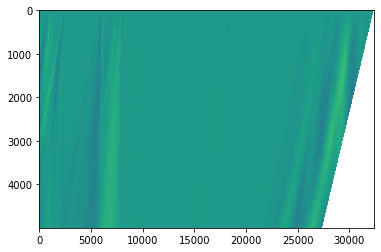

In [12]:
fdmtfile('guppi_59334_59899_6179049297_ProxCen_S_0001.0002.fil',5000, False)

In [6]:
#fdmtfile('guppi_59334_59899_6179049297_ProxCen_S_0001.0002.fil',3000, True)

In [7]:
# from numba import cuda

# cuda.current_context().deallocations.clear()

In [8]:
#!nvidia-smi